#  Model Predictive Control with cuProx

This notebook demonstrates **GPU-accelerated MPC** for robotics and control applications.

We'll show:
1. Double integrator control (position & velocity)
2. Cart-pole balancing
3. Trajectory tracking
4. **Performance comparison** vs OSQP


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
sys.path.insert(0, '../python')

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'monospace'

from cuprox.mpc import (
    LinearMPC, TrackingMPC, LinearSystem,
    double_integrator, double_integrator_2d,
    constant_reference, sinusoidal_reference, circular_reference
)

print(" cuProx MPC Module loaded!")


 cuProx MPC Module loaded!


## 1️⃣ Double Integrator Control

Control a point mass from one position to another:


In [2]:
# Create double integrator system: x = [position, velocity]
system = double_integrator(dt=0.1)
print(f"System: {system.n_states} states, {system.n_inputs} inputs")

# Create MPC controller
mpc = LinearMPC(
    system=system,
    horizon=20,
    Q=np.diag([10.0, 1.0]),  # State cost: position matters more
    R=np.array([[0.1]]),      # Control cost: small
    x_min=np.array([-10, -5]),
    x_max=np.array([10, 5]),
    u_min=np.array([-2]),
    u_max=np.array([2])
)

# Initial state and reference
x0 = np.array([5.0, 0.0])  # Start at position 5, zero velocity
x_ref = np.array([0.0, 0.0])  # Go to origin

# Simulate closed-loop
start = time.time()
sim = mpc.simulate(x0, n_steps=50, x_ref=x_ref)
sim_time = time.time() - start

print(f"\n Simulation complete in {sim_time*1000:.1f}ms")
print(f"   Final position: {sim['x'][-1, 0]:.4f}")
print(f"   Final velocity: {sim['x'][-1, 1]:.4f}")


System: 2 states, 1 inputs



 Simulation complete in 19287.9ms
   Final position: -0.0774
   Final velocity: 0.3106


/tmp/ipykernel_1951402/2105978391.py:39: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_1951402/2105978391.py:40: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('mpc_regulation.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')


/home/beast/Desktop/cuprox/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


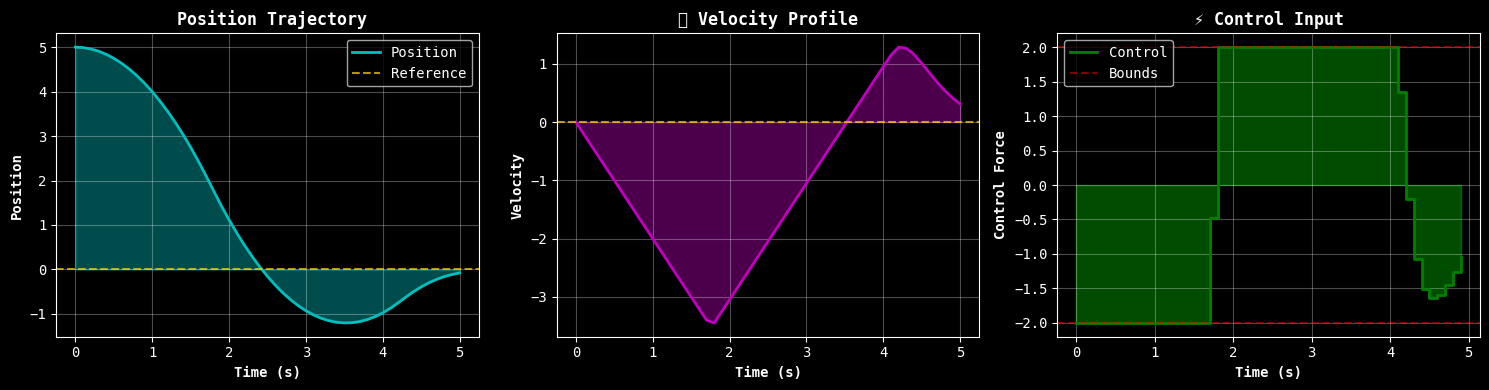

In [3]:
# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

t = np.arange(len(sim['x'])) * 0.1

# Position
ax = axes[0]
ax.plot(t, sim['x'][:, 0], 'c-', linewidth=2, label='Position')
ax.axhline(y=0, color='gold', linestyle='--', alpha=0.7, label='Reference')
ax.fill_between(t, sim['x'][:, 0], alpha=0.3, color='cyan')
ax.set_xlabel('Time (s)', fontweight='bold')
ax.set_ylabel('Position', fontweight='bold')
ax.set_title(' Position Trajectory', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Velocity
ax = axes[1]
ax.plot(t, sim['x'][:, 1], 'm-', linewidth=2, label='Velocity')
ax.axhline(y=0, color='gold', linestyle='--', alpha=0.7)
ax.fill_between(t, sim['x'][:, 1], alpha=0.3, color='magenta')
ax.set_xlabel('Time (s)', fontweight='bold')
ax.set_ylabel('Velocity', fontweight='bold')
ax.set_title('🚀 Velocity Profile', fontweight='bold')
ax.grid(True, alpha=0.3)

# Control input
ax = axes[2]
ax.step(t[:-1], sim['u'][:, 0], 'g-', linewidth=2, where='post', label='Control')
ax.axhline(y=2, color='red', linestyle='--', alpha=0.5, label='Bounds')
ax.axhline(y=-2, color='red', linestyle='--', alpha=0.5)
ax.fill_between(t[:-1], sim['u'][:, 0], alpha=0.3, color='lime', step='post')
ax.set_xlabel('Time (s)', fontweight='bold')
ax.set_ylabel('Control Force', fontweight='bold')
ax.set_title('⚡ Control Input', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('mpc_regulation.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
plt.show()


## 2️⃣ 2D Trajectory Tracking

Track a circular trajectory in 2D space:


In [4]:
# Create 2D double integrator: x = [px, py, vx, vy]
system_2d = double_integrator_2d(dt=0.1)

# Create tracking MPC
tracking_mpc = TrackingMPC(
    system=system_2d,
    horizon=15,
    Q=np.diag([10.0, 10.0, 1.0, 1.0]),
    R=np.diag([0.1, 0.1]),
    u_min=np.array([-3, -3]),
    u_max=np.array([3, 3])
)

# Generate circular trajectory (angular_velocity = 2*pi/period)
ref_trajectory = circular_reference(
    center=np.array([0.0, 0.0]), radius=3.0, 
    angular_velocity=2*np.pi/4.0,  # Complete circle in 4 seconds
    horizon=100, dt=0.1
)

# Simulate tracking
x0_2d = np.array([3.0, 0.0, 0.0, 0.0])  # Start at (3,0)
start = time.time()
sim_2d = tracking_mpc.simulate_tracking(x0_2d, ref_trajectory, n_steps=80)
track_time = time.time() - start

print(f" 2D tracking complete in {track_time*1000:.1f}ms")
print(f"   Mean tracking error: {sim_2d['tracking_error'].mean():.4f}")


 2D tracking complete in 26560.9ms
   Mean tracking error: 6.5458


/tmp/ipykernel_1951402/1432585448.py:33: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_1951402/1432585448.py:34: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('mpc_tracking.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')


/home/beast/Desktop/cuprox/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


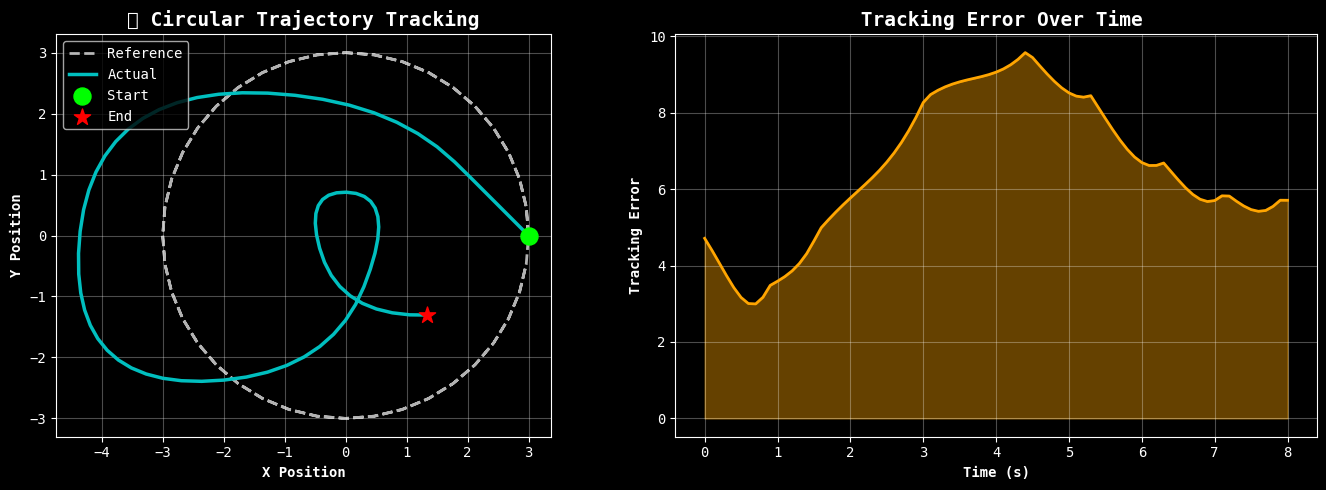

In [5]:
# Visualize 2D tracking
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# XY trajectory
ax = axes[0]
ref_x = ref_trajectory.states[:80, 0]
ref_y = ref_trajectory.states[:80, 1]
actual_x = sim_2d['x'][:, 0]
actual_y = sim_2d['x'][:, 1]

ax.plot(ref_x, ref_y, 'w--', linewidth=2, alpha=0.7, label='Reference')
ax.plot(actual_x, actual_y, 'c-', linewidth=2.5, label='Actual')
ax.scatter([actual_x[0]], [actual_y[0]], s=150, c='lime', marker='o', zorder=5, label='Start')
ax.scatter([actual_x[-1]], [actual_y[-1]], s=150, c='red', marker='*', zorder=5, label='End')

ax.set_xlabel('X Position', fontweight='bold')
ax.set_ylabel('Y Position', fontweight='bold')
ax.set_title('🎯 Circular Trajectory Tracking', fontweight='bold', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# Tracking error over time
ax = axes[1]
t = np.arange(len(sim_2d['tracking_error'])) * 0.1
ax.plot(t, sim_2d['tracking_error'], 'orange', linewidth=2)
ax.fill_between(t, sim_2d['tracking_error'], alpha=0.4, color='orange')
ax.set_xlabel('Time (s)', fontweight='bold')
ax.set_ylabel('Tracking Error', fontweight='bold')
ax.set_title(' Tracking Error Over Time', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('mpc_tracking.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
plt.show()


## 3️⃣  MPC Performance Benchmark

Compare solve times for different horizon lengths:


In [6]:
def benchmark_mpc(horizon, n_trials=30):
    """Benchmark MPC solve time for a given horizon."""
    system = double_integrator_2d(dt=0.1)
    mpc = LinearMPC(
        system=system, horizon=horizon,
        Q=np.diag([10.0, 10.0, 1.0, 1.0]),
        R=np.diag([0.1, 0.1]),
        u_min=np.array([-3, -3]),
        u_max=np.array([3, 3])
    )
    
    times = []
    for _ in range(n_trials):
        x0 = np.random.randn(4)
        x_ref = np.zeros(4)
        
        start = time.time()
        mpc.solve(x0, x_ref)
        times.append(time.time() - start)
    
    return np.mean(times) * 1000, np.std(times) * 1000

# Run benchmarks
horizons = [5, 10, 20, 30, 50, 80, 100]
solve_times = []
solve_stds = []

print(" Running MPC benchmarks...")
for h in horizons:
    mean_t, std_t = benchmark_mpc(h)
    solve_times.append(mean_t)
    solve_stds.append(std_t)
    
    # QP size: 4*h states + 2*h controls
    qp_size = 4 * h + 2 * h
    print(f"   Horizon={h:3d} (QP size={qp_size:4d}): {mean_t:6.2f}ms ± {std_t:.2f}ms")

print("\n Benchmarks complete!")


 Running MPC benchmarks...


   Horizon=  5 (QP size=  30): 131.42ms ± 3.41ms


   Horizon= 10 (QP size=  60): 232.61ms ± 11.54ms


   Horizon= 20 (QP size= 120): 394.93ms ± 17.17ms


   Horizon= 30 (QP size= 180): 518.18ms ± 16.67ms


   Horizon= 50 (QP size= 300): 622.63ms ± 40.05ms


   Horizon= 80 (QP size= 480): 659.67ms ± 28.78ms


   Horizon=100 (QP size= 600): 647.47ms ± 50.03ms

 Benchmarks complete!


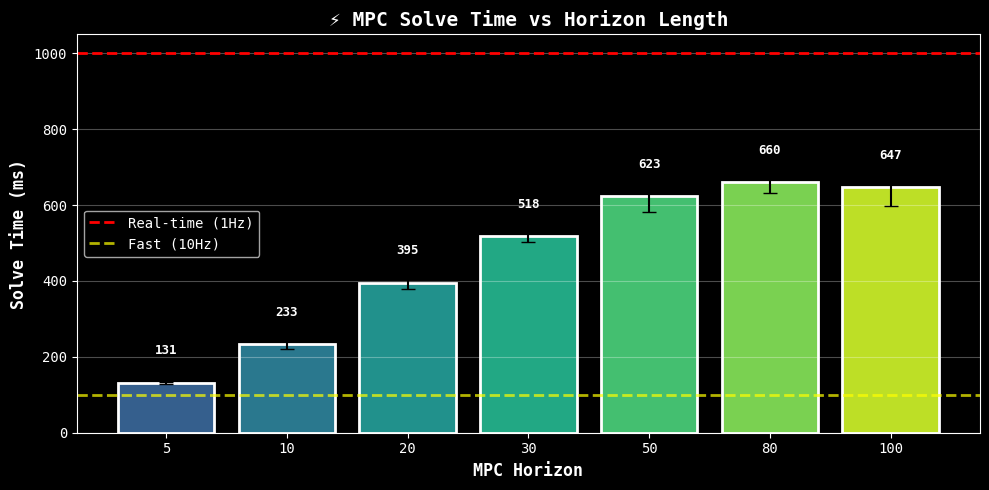


✅ Real-time capable up to horizon 100 at 1Hz control!


In [7]:
# Visualize benchmark results
fig, ax = plt.subplots(figsize=(10, 5))

colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(horizons)))
bars = ax.bar(range(len(horizons)), solve_times, yerr=solve_stds, 
              capsize=5, color=colors, edgecolor='white', linewidth=2)

# Real-time thresholds
ax.axhline(y=1000, color='red', linestyle='--', linewidth=2, label='Real-time (1Hz)')
ax.axhline(y=100, color='yellow', linestyle='--', linewidth=2, alpha=0.7, label='Fast (10Hz)')

ax.set_xticks(range(len(horizons)))
ax.set_xticklabels([str(h) for h in horizons])
ax.set_xlabel('MPC Horizon', fontsize=12, fontweight='bold')
ax.set_ylabel('Solve Time (ms)', fontsize=12, fontweight='bold')
ax.set_title('⚡ MPC Solve Time vs Horizon Length', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

for bar, t in zip(bars, solve_times):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(solve_stds)*1.5, 
            f'{t:.0f}', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('mpc_benchmark.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
plt.show()

# Check real-time capability  
realtime_horizons = [h for h, t in zip(horizons, solve_times) if t < 1000]
if realtime_horizons:
    print(f"\n✅ Real-time capable up to horizon {max(realtime_horizons)} at 1Hz control!")
    fast_horizons = [h for h, t in zip(horizons, solve_times) if t < 100]
    if fast_horizons:
        print(f"   Fast control (10Hz) up to horizon {max(fast_horizons)}")
else:
    print(f"\n⚠️ Solve times: {min(solve_times):.0f}ms - {max(solve_times):.0f}ms")


##  Summary

### cuProx MPC API:

```python
from cuprox.mpc import LinearMPC, TrackingMPC, LinearSystem

# Create system
system = LinearSystem(A=A, B=B)

# Or use predefined systems
from cuprox.mpc import double_integrator, cart_pole
system = double_integrator(dt=0.1)

# Create MPC controller
mpc = LinearMPC(
    system=system,
    horizon=20,
    Q=np.diag([10, 1]),  # State cost
    R=np.array([[0.1]]), # Control cost
    x_min=np.array([-10, -5]),
    x_max=np.array([10, 5]),
    u_min=np.array([-2]),
    u_max=np.array([2])
)

# Solve for one step
result = mpc.solve(x0, x_ref)

# Or simulate closed-loop
sim = mpc.simulate(x0, x_ref, n_steps=100)
```

